# Package import

In [1]:
import pandas as pd
import os 
import json
import re
import os
import fitz
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.decomposition import PCA
import PyPDF2
from sklearn.metrics import silhouette_score
import cv2
import numpy as np
import multiprocessing
from skimage.transform import rotate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt
import pytesseract

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


# Create List

In [2]:
pdf_path = []
pdf_name = []

def list_files(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            pdf_path.append(file_path)
            pdf_name.append(filename)

list_files(r"G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc")
pdf_dict = dict(zip(pdf_name, pdf_path))

# Transform PDF to PNG

In [3]:
pdf_dir = 'G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc'
output_dir = 'G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc_png'
dpi = 400 # set the DPI value here

for filename in os.listdir(pdf_dir):
    if filename.endswith('.pdf'):
        pdf_path = os.path.join(pdf_dir, filename)
        doc = fitz.open(pdf_path)
        for page_num, page in enumerate(doc):
            name= filename.split('.')[0]
            output_path = os.path.join(output_dir, f'{name}_{page_num}.png')
            pix = page.get_pixmap(matrix=fitz.Matrix(dpi/72, dpi/72)) # set the DPI value here
            pix.save(output_path)
        doc.close()

In [ ]:
# code to get index where code being stopped and need to resume from the point
pdf_name='.pdf'
index = [i for i, path in enumerate(pdf_path) if pdf_name in path]
print(index)

# list png

In [4]:
png_path = []
png_name = []

def list_files(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            png_path.append(file_path)
            png_name.append(filename)

list_files(r"G:\VSCode\Personal_work\Clustering_pdf_sklearn\dummy_doc_png")
png_dict = dict(zip(png_name, png_path))

# Image Preprocessing

In [5]:
def image_preprocessing(png, destination):


    # Read the image file
    image = cv2.imread(png)

    # Convert the image to grayscale
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extract the value channel
    v_channel = hsv_image[:,:,2]

    # Apply histogram equalization to improve contrast
    # equalized_v_channel = cv2.equalizeHist(v_channel)

    # # Apply thresholding to remove distortion
    # thresholded_image = cv2.adaptiveThreshold(
    #     equalized_v_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 1)

    # Apply Gaussian blur to remove noise
    blurred_image = cv2.GaussianBlur(v_channel, (3, 3), 0)

    file_name = destination + "\\" +os.path.basename(png).split("\\")[-1]
    # Save the pre-processed image
    cv2.imwrite(file_name, blurred_image)

In [6]:
destination = r'G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc_png_processed'
for png in png_path:
    image_preprocessing(png,destination)

# Rotate image 

In [8]:
def rotate_im(image, angle):
    image_height = image.shape[0]
    image_width = image.shape[1]
    diagonal_square = (image_width*image_width) + (
        image_height* image_height
    )
    #
    diagonal = round(math.sqrt(diagonal_square))
    padding_top = round((diagonal-image_height) / 2)
    padding_bottom = round((diagonal-image_height) / 2)
    padding_right = round((diagonal-image_width) / 2)
    padding_left = round((diagonal-image_width) / 2)
    padded_image = cv2.copyMakeBorder(image,
                                      top=padding_top,
                                      bottom=padding_bottom,
                                      left=padding_left,
                                      right=padding_right,
                                      borderType=cv2.BORDER_CONSTANT,
                                      value=0
            )
    padded_height = padded_image.shape[0]
    padded_width = padded_image.shape[1]
    transform_matrix = cv2.getRotationMatrix2D(
                (padded_height/2,
                 padded_width/2), # center
                angle, # angle
      1.0) # scale
    rotated_image = cv2.warpAffine(padded_image,
                                   transform_matrix,
                                   (diagonal, diagonal),
                                   flags=cv2.INTER_LANCZOS4)
    return rotated_image

In [9]:
def image_rotation(png, destination):
     
    # Read image from URL
    # resp = urllib.request.urlopen(' ')

    # Read image from local
    try:
        #get the image
        image = cv2.imread(png)

        #get the orientation of the image
        rot_data = pytesseract.image_to_osd(image);

        rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
        #get the angle
        angle = float(rot)
        if angle > 0:
            angle = 360 - angle
        #rotate the image
        data=rotate_im(image,angle)
        file_name = destination + "\\" +os.path.basename(png).split(".")[0] + ".png"
        # Save the pre-processed image
        cv2.imwrite(file_name, data)
    except: #in case of documents preprocessed in bad quality 
        print('not available to rotate png in processed')

        name=png.split('\\')[-1]
        base=r'G:\VSCode\Personal_work\Clustering_pdf_sklearn\dummy_doc_png/'
        
        png2=base+name
        image = cv2.imread(png2)
        try:
            image = cv2.imread(png)
            #get the orientation of the image
            rot_data = pytesseract.image_to_osd(image);

            rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
             #get the angle
            angle = float(rot)
            if angle > 0:
                angle = 360 - angle
            #rotate the image
            data=rotate_im(image,angle)
            file_name = destination + "\\" +os.path.basename(png).split(".")[0] + ".png"
            # Save the pre-processed image
            cv2.imwrite(file_name, data)
        except:
            file_name = destination + "\\" +os.path.basename(png).split(".")[0] + ".png"
            cv2.imwrite(file_name, image)

In [10]:
png_rotate_path = []
png_rotate_name = []

def list_files(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            png_rotate_path.append(file_path)
            png_rotate_name.append(filename)

list_files(r"G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc_png_processed")
png_rotate_dict = dict(zip(png_rotate_name, png_rotate_path))

In [11]:
destination = r'G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc_png_processed_rotated'
for png in png_rotate_path:
    image_rotation(png,destination)

not available to rotate png in processed
not available to rotate png in processed
not available to rotate png in processed


# Text Extraction

In [12]:
png_cleaned_path = []
png_cleaned_name = []

def list_files(path):
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            png_cleaned_path.append(file_path)
            png_cleaned_name.append(filename)
list_files(r"G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc_png_processed_rotated")
png_cleaned_dict = dict(zip(png_cleaned_name, png_cleaned_path))

In [14]:
from PIL import Image

full_text = {}
config = r'--oem 1 --psm 6 --user-words dictionary.txt'

for i, pt in enumerate(png_cleaned_dict):
    try:
        image = Image.open(r"G:\VSCode\GithubRepo\Healthcare_Documents_Clustering_With_OCR\dummy_doc_png_processed_rotated/" + pt)

        # Read the image file
        text = pytesseract.image_to_string(image, lang='eng', config=config)

        full_text[pt] = text
    except:
        pass

In [41]:
# import json
# with open('full_text.json','w') as f:
#     json.dump(full_text,f, indent=4)

# Data cleaning and reprocessing null values

In [15]:
df= pd.DataFrame.from_dict(png_cleaned_dict , orient='index')
df=df.reset_index()
df=df.rename(columns={df.columns[0]:'doc_name',df.columns[1]: 'png_path'})
df['group'] = df['doc_name'].str.split('_').str[0]
result = df.groupby('group').agg({'png_path': ' '.join})
result= result.reset_index()
result.columns = ['doc_name','png_path']
result['doc_name'] = result['doc_name'].apply(lambda x: x + '.png' if not x.endswith('.png') else x)
result.to_csv('full_text_all_train_path.csv')

In [16]:
df2= pd.DataFrame.from_dict(full_text, orient='index')
df2=df2.reset_index()
df2=df2.rename(columns={df2.columns[0]:'doc_name',df2.columns[1]: 'full_text'})
df2['group'] = df2['doc_name'].str.split('_').str[0]
result2 = df2.groupby('group').agg({'full_text': ' '.join})
result2= result2.reset_index()
result2.columns = ['doc_name','full_text']
result2['doc_name'] = result2['doc_name'].apply(lambda x: x + '.png' if not x.endswith('.png') else x)
result2.to_csv('full_text_all_train.csv')

In [17]:
df_png = result.merge(result2, on='doc_name', how='left')
df_png

,doc_name,png_path,full_text
0,dummy-type1-1.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Referral\n213123\n123\nDoctor’s name & Address...
1,dummy-type1-2.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Referral\nDoctor’s name & Address _Dr Some one...
2,dummy-type1-3.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Referral\n23123232\nDoctor’s name & Address _ ...
3,dummy-type10-1.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,"A, ; Specialist Consultation Referral Form\nto..."
4,dummy-type2-1.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,advice\nThe voice of independent advice\nSampl...
5,dummy-type2-2.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,advice\nThe voice of independent advice\nSampl...
6,dummy-type2-3.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,advice ux\nThe voice of independent advice\nSa...
7,dummy-type3-1.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Holland Bloorview Appointment Services: 150 Ki...
8,dummy-type4-1.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,TRIAGING ADMIN CODE (COMPLETED ON RECEIPT): En...
9,dummy-type4-2.png,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,TRIAGING ADMIN CODE (COMPLETED ON RECEIPT): En...


In [47]:
# df_png.to_csv('df_png.csv')

# SK-Learn Kmeans clustering

In [ ]:
# read csv
# df_png = pd.read_csv('df_png.csv', index_col=0)

In [19]:
# import the list of relevant words
with open('dictionary.txt') as file:
	lines = file.readlines()
	lines = [line.strip() for line in lines]
	file.close()
relevant_words = lines
# Initialize TfidfVectorizer with your parameters 
tfidf = TfidfVectorizer(stop_words='english') 
# Fit and transform your text data into a TF-IDF feature matrix 
tfidf_matrix = tfidf.fit_transform(df_png['full_text']) 
# Get the indices of relevant words in the vocabulary 
relevant_word_indices = [tfidf.vocabulary_.get(word) for word in relevant_words] 
# Adjust the IDF values of relevant words 
idf = tfidf.idf_ 
for i in relevant_word_indices:
	 idf[i] *= 5 
# Five times the IDF weight of relevant words # Use the adjusted TF-IDF feature matrix to perform K-means clustering 


In [20]:
# Use elbow method to find the optimal number of clusters
inertias = []
silhouette_scores=[]
for k in range(2, 18,1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))

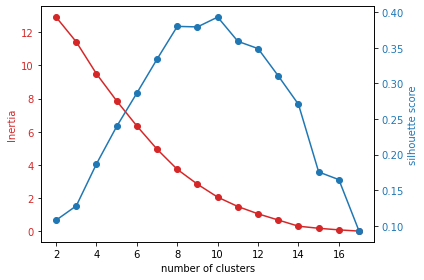

In [21]:
# Use silhouette method to evaluate the clustering performance

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(range(2, 18,1), inertias, marker ='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('silhouette score', color=color)
ax2.plot(range(2, 18,1), silhouette_scores, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [22]:
# Based on the elbow plot, choose the optimal number of clusters
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(tfidf_matrix)

# Use silhouette method to evaluate the clustering performance
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 10 The average silhouette_score is : 0.3930688805400409


# Export Results

In [23]:
import joblib
joblib.dump(kmeans, "kmeans_full_train_ocr.joblib")

['kmeans_full_train_ocr.joblib']

In [24]:
import pickle
with open("kmeans_full_train_ocr.pkl", "wb") as file:
    pickle.dump(kmeans, file)

In [25]:

cluster_pd = pd.DataFrame(clusters, columns = ['cluster'])
cluster_pd.sort_values(by=["cluster"], inplace = True)
cluster_merge = cluster_pd.merge(df_png,left_index=True, right_index=True,how='outer')
cluster_merge.sort_values(by=["cluster"], inplace = True)
cluster_merge['doc_name'] = cluster_merge['doc_name'].str.replace( '.png','.pdf')

In [57]:
cluster_merge.to_csv('train_cluster.csv')

In [58]:
cluster_merge.to_excel('train_cluster.xlsx')

In [26]:
cluster_merge

,cluster,doc_name,png_path,full_text
15,0,dummy-type8-2.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,"al, wie rh ~\nie INOVA MEDICAL\nge GROUP\nPati..."
14,0,dummy-type8-1.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,es .\nae (NOVA MEDICAL\nls GROUP\nPatient Regi...
8,1,dummy-type4-1.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,TRIAGING ADMIN CODE (COMPLETED ON RECEIPT): En...
9,1,dummy-type4-2.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,TRIAGING ADMIN CODE (COMPLETED ON RECEIPT): En...
0,2,dummy-type1-1.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Referral\n213123\n123\nDoctor’s name & Address...
2,2,dummy-type1-3.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Referral\n23123232\nDoctor’s name & Address _ ...
1,2,dummy-type1-2.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,Referral\nDoctor’s name & Address _Dr Some one...
5,3,dummy-type2-2.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,advice\nThe voice of independent advice\nSampl...
6,3,dummy-type2-3.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,advice ux\nThe voice of independent advice\nSa...
4,3,dummy-type2-1.pdf,G:\VSCode\GithubRepo\Healthcare_Documents_Clus...,advice\nThe voice of independent advice\nSampl...
